In [8]:
import torch
import pandas as pd
import numpy as np
import math

import textwrap

from diffusers import StableDiffusionPipeline
from huggingface_hub import notebook_login

import matplotlib.pyplot as plt
from PIL import Image

notebook_login()

In [9]:
pipe = StableDiffusionPipeline.from_pretrained(
    "Manojb/stable-diffusion-2-1-base", # "CompVis/stable-diffusion-v1-4",
    safety_checker=None,
    torch_dtype=torch.float16
).to("cuda")

Loading pipeline components...: 100%|██████████| 6/6 [00:02<00:00,  2.22it/s]


In [4]:
def generate(prompts: list[str], num_inference_steps: int=30, guidance_scale: int=7.5):
  images = pipe(prompts, num_inference_steps=num_inference_steps, guidance_scale=guidance_scale).images

  return images


def get_text_encoder_activations(pipe: StableDiffusionPipeline, prompts: list[str]):
    inputs = pipe.tokenizer(
        prompts,
        padding="max_length",
        max_length=pipe.tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt"
    ).to(pipe.text_encoder.device)

    with torch.inference_mode():
        outputs = pipe.text_encoder(**inputs, output_hidden_states=True)

    return outputs.hidden_states



def get_unet_residual_stream(
    pipe,
    prompts: list[str],
    num_inference_steps: int = 30,
    guidance_scale: float = 7.5
):
    residuals_dict = {}
    handles = []

    def save_residuals(name):
        def hook(module, input, output):
            # I ResnetBlock restituiscono una tupla: (hidden_state, residual)
            residual = output[1] if isinstance(output, tuple) else output
            # Accumula i residuals in una lista
            if isinstance(residual, torch.Tensor):
                residuals_dict.setdefault(name, []).append(residual.detach().cpu())
            else:
                residuals_dict.setdefault(name, []).extend([r.detach().cpu() for r in residual])
        return hook

    for i, block in enumerate(pipe.unet.down_blocks):
        for j, resnet in enumerate(block.resnets):
            handles.append(resnet.register_forward_hook(save_residuals(f"down_block_{i}_resnet_{j}")))

    for j, resnet in enumerate(pipe.unet.mid_block.resnets):
        handles.append(resnet.register_forward_hook(save_residuals(f"mid_block_resnet_{j}")))

    for i, block in enumerate(pipe.unet.up_blocks):
        for j, resnet in enumerate(block.resnets):
            handles.append(resnet.register_forward_hook(save_residuals(f"up_block_{i}_resnet_{j}")))

    with torch.inference_mode():
        _ = pipe(
            prompts,
            num_inference_steps=num_inference_steps,
            guidance_scale=guidance_scale,
        )

    # Rimuovi gli hook
    for h in handles:
        h.remove()

    return residuals_dict

def show_images(images: list[Image.Image], prompts: list[str], cols: int = 2, width: int = 40) -> None:
    assert len(images) == len(prompts)

    rows = math.ceil(len(images) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(3 * cols, 3 * rows))

    if isinstance(axes, np.ndarray):
        axes = axes.flatten()
    else:
        axes = [axes]

    for ax in axes[len(images):]:
        ax.axis('off')

    for ax, img, prompt in zip(axes, images, prompts):
        ax.imshow(img)
        ax.axis('off')
        wrapped_prompt = "\n".join(textwrap.wrap(prompt, width=width))
        ax.text(0.5, -0.05, wrapped_prompt, fontsize=10, ha='center', va='top', transform=ax.transAxes)
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_color('black')
            spine.set_linewidth(1)

    plt.tight_layout()
    plt.show()

In [6]:
#dogs_dataset = pd.read_csv('/kaggle/input/prompts-steering/dogs.csv')
dogs_dataset = pd.read_csv('dogs.csv')
dog_prompts = dogs_dataset['positive'].tolist()
non_dog_prompts = dogs_dataset['negative'].tolist()

100%|██████████| 30/30 [00:07<00:00,  4.15it/s]


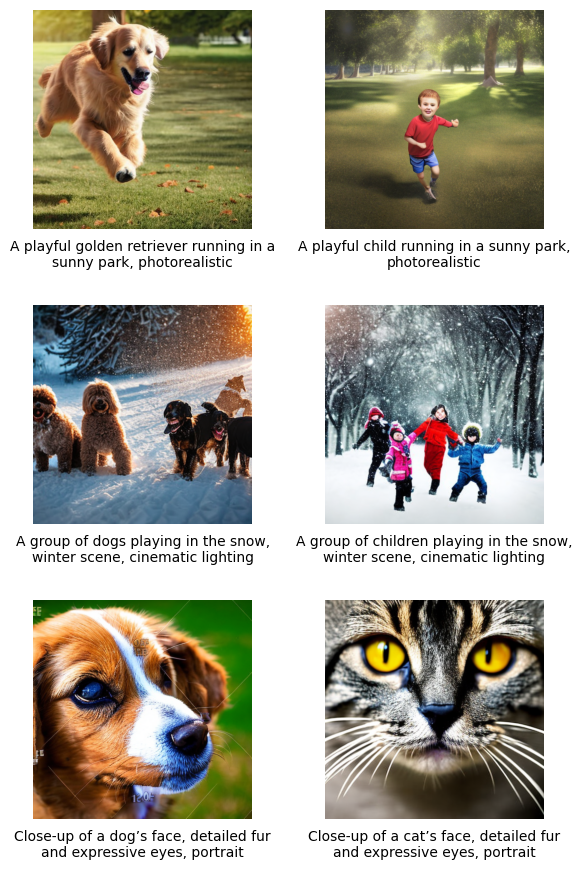

In [10]:
batch_size = 3
images_no = 3 # len(dog_prompts)

all_images = []
all_prompts = []

for i in range(0, images_no, batch_size):
    pos_batch = dog_prompts[i:i+batch_size]
    neg_batch = non_dog_prompts[i:i+batch_size]

    pos_images = generate(pos_batch)
    neg_images = generate(neg_batch)

    for p_img, n_img, p_prompt, n_prompt in zip(pos_images, neg_images, pos_batch, neg_batch):
        all_images.append(p_img)
        all_images.append(n_img)
        all_prompts.append(p_prompt)
        all_prompts.append(n_prompt)

show_images(all_images, all_prompts, cols=2)

In [11]:
dog_activations = get_unet_residual_stream(pipe, dog_prompts[:3])

100%|██████████| 30/30 [00:09<00:00,  3.01it/s]


In [12]:
#print(pipe.unet)

for layer_name, activation in dog_activations.items():
    print(f'Layer {layer_name}: {len(activation)}')

Layer down_block_0_resnet_0: 31
Layer down_block_0_resnet_1: 31
Layer down_block_1_resnet_0: 31
Layer down_block_1_resnet_1: 31
Layer down_block_2_resnet_0: 31
Layer down_block_2_resnet_1: 31
Layer down_block_3_resnet_0: 31
Layer down_block_3_resnet_1: 31
Layer mid_block_resnet_0: 31
Layer mid_block_resnet_1: 31
Layer up_block_0_resnet_0: 31
Layer up_block_0_resnet_1: 31
Layer up_block_0_resnet_2: 31
Layer up_block_1_resnet_0: 31
Layer up_block_1_resnet_1: 31
Layer up_block_1_resnet_2: 31
Layer up_block_2_resnet_0: 31
Layer up_block_2_resnet_1: 31
Layer up_block_2_resnet_2: 31
Layer up_block_3_resnet_0: 31
Layer up_block_3_resnet_1: 31
Layer up_block_3_resnet_2: 31


# Inference part

In [ ]:
def generate_with_steering(
    pipe: StableDiffusionPipeline,
    prompt: str,
    steering_vectors: dict[str, torch.Tensor],
    num_inference_steps: int = 30,
    guidance_scale: float = 7.5,
    mode: str = "subtract",   # or "add"
):
    """
    Run Stable Diffusion with steering vectors applied to the U-Net residual stream
    at the last diffusion timestep.

    Args:
        pipe: StableDiffusionPipeline
        prompt: prompt
        steering_vectors: dict[layer_name -> tensor]
            layer_name must be one of:
              - "down_block_{i}_resnet_{j}"
              - "mid_block_resnet_{j}"
              - "up_block_{i}_resnet_{j}"
        num_inference_steps: diffusion steps
        guidance_scale: CFG scale
        mode: "subtract" or "add" the steering vector
    """

    # --- Keep some state about which diffusion step we are on ---
    current_step = 0
    target_step = num_inference_steps - 1  # "last" step

    # Monkey-patch unet.forward to count how many times it's called
    original_unet_forward = pipe.unet.forward

    def wrapped_unet_forward(*args, **kwargs):
        nonlocal current_step
        out = original_unet_forward(*args, **kwargs)
        current_step += 1
        return out

    pipe.unet.forward = wrapped_unet_forward

    # --- Hooks that apply steering vectors on specific layers ---

    handles = []

    def make_steering_hook(layer_name: str):
        vec = steering_vectors.get(layer_name, None)
        if vec is None:
            # No steering for this layer
            def noop_hook(module, input, output):
                return output
            return noop_hook

        def hook(module, input, output):
            # Only steer on the last diffusion timestep
            if current_step - 1 != target_step:  # current_step is incremented after forward
                return output
            print(f"[STEERING] applying vector at layer {layer_name}, step {current_step-1}")

            # Figure out what the "residual" is for this block
            if isinstance(output, tuple):
                hidden, residual = output
            else:
                hidden, residual = None, output

            steer = vec.to(residual.device, residual.dtype)

            if mode == "subtract":
                residual = residual - steer
            else:
                residual = residual + steer

            # Return the modified output in the same structure
            if hidden is None:
                return residual
            else:
                return (hidden, residual)

        return hook

    # Register hooks only where we have vectors
    for i, block in enumerate(pipe.unet.down_blocks):
        for j, resnet in enumerate(block.resnets):
            name = f"down_block_{i}_resnet_{j}"
            if name in steering_vectors:
                handles.append(resnet.register_forward_hook(make_steering_hook(name)))

    for j, resnet in enumerate(pipe.unet.mid_block.resnets):
        name = f"mid_block_resnet_{j}"
        if name in steering_vectors:
            handles.append(resnet.register_forward_hook(make_steering_hook(name)))

    for i, block in enumerate(pipe.unet.up_blocks):
        for j, resnet in enumerate(block.resnets):
            name = f"up_block_{i}_resnet_{j}"
            if name in steering_vectors:
                handles.append(resnet.register_forward_hook(make_steering_hook(name)))

    # --- Run the pipeline with hooks active ---
    try:
        images = pipe(
            prompt,
            num_inference_steps=num_inference_steps,
            guidance_scale=guidance_scale
        ).images
    finally:
        # --- Cleanup: remove hooks and restore original forward ---
        for h in handles:
            h.remove()
        pipe.unet.forward = original_unet_forward

    return images


100%|██████████| 30/30 [00:02<00:00, 10.30it/s]


[STEERING] applying vector at layer down_block_1_resnet_0, step 29
[STEERING] applying vector at layer mid_block_resnet_0, step 29
[STEERING] applying vector at layer up_block_1_resnet_0, step 29


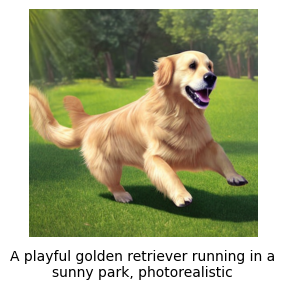

In [ ]:
# Get some activations to know the shapes
dog_acts = get_unet_residual_stream(pipe, dog_prompts[:1])

# Build a random steering vector for one layer, using the last timestep activation
layer_name1 = "mid_block_resnet_0"
example_vec1 = torch.randn_like(dog_acts[layer_name1][-1])

layer_name2 = "up_block_1_resnet_0"
example_vec2 = torch.randn_like(dog_acts[layer_name2][-1])

layer_name3 = "down_block_1_resnet_0"
example_vec3 = torch.randn_like(dog_acts[layer_name3][-1])

steering_vectors = {
    layer_name1: example_vec1,
    layer_name2: example_vec2,
    layer_name3: example_vec3
    
}

# Run generation with steering
prompt = [pos_batch[0]]
steered_images = generate_with_steering(
    pipe,
    prompt[0],
    steering_vectors,
    num_inference_steps=30,
    guidance_scale=7.5,
    mode="substract",   # or "add"
)

# Visualize
show_images(steered_images, prompt, cols=1)
